In [47]:
import os
import sys
import json
import torch
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from torchsummary import summary
import matplotlib.pyplot as plt
from model_dev.dataloader import data_provider
from model_dev.stock_picker import StockPicker
from visualize_single import Visualize, draw_barchart
from scatter_plot import Scatter
from model_dev.utills import read_default_args, detect_constant_price, load_model
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/Users/shiva/Desktop/maestro/model_dev/')
from expirement import ExpMain


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## DLinear

In [48]:
default_args = read_default_args()

In [49]:
config_file = '../../configs/config_shiva.json'
config = json.load(open(config_file))
data_dir = config['data_dir']
raw_dir = "{}/{}".format(data_dir, config['raw_data_dir'])
csv_dir = "{}/{}".format(data_dir, config['raw_data_csv'])
ltsf = "{}/ltsf".format(data_dir)

In [52]:
args = {
   'root_path': ltsf,
   'checkpoints': '{}/checkpoints/'.format(data_dir),
   'data_path': '03_23.csv',
   'seq_len': 600,
   'pred_len': 60,
   'batch_size': 1,
   'learning_rate': 0.025,
   'train_only': True,
   'train_epochs': 20,
   'data_segment': None,
   'model': 'nlinear_attention',
   'enc_in': 270,
   'patience': 5,
   'target': 0
}

for key, value in args.items():
    default_args[key] = value

args = argparse.Namespace(**default_args)
setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target)
weights = os.listdir("{}/{}".format(args.checkpoints, setting))
sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
sorted_weights

['checkpoint_0.9430.pth', 'checkpoint_0.6760.pth']

In [57]:
vis = Visualize(args, mode='val', setting=setting, weights=sorted_weights[-1], title_meta=1, decision_log=0)
loss_list, preds, trues = [], [], []
for ts in tqdm(range(0, 2000, 90)):
    pred, true, loss = vis.plot(ts, plot=1, plt_len=None)
    preds.append(pred)
    trues.append(true)
    loss_list.append(loss)

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl600_pl60_ds_03_23_tg_0/checkpoint_0.6760.pth


ValueError: __len__() should return >= 0

In [ ]:
np.mean(loss_list)

0.022407685913752143

In [ ]:
exp = ExpMain(args)
preds_, trues_, train_loss_ = exp.test(setting, 'train')

Use CPU
Total number of parameters is: 36331
train 9316
train 9316
loading model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl600_pl60_ds_03_23_tg_0_test/checkpoint_0.0302.pth


 88%|████████▊ | 8226/9316 [00:13<00:00, 1541.52it/s]

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl600_pl60_ds_03_23_tg_1_test/checkpoint_0.0088.pth
train 9316


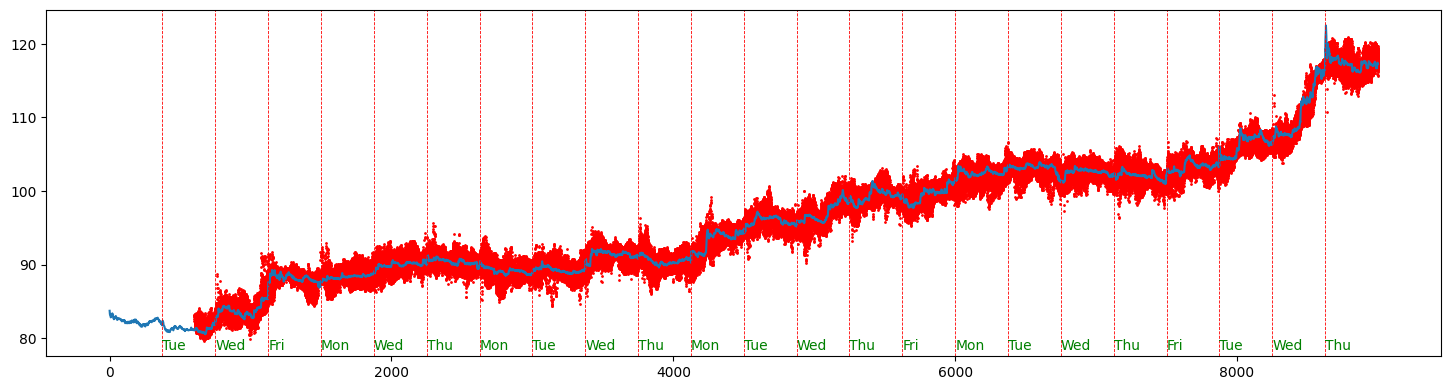

In [ ]:
scatter = Scatter(args, setting, sorted_weights[-1], mode='train')
scatter.plot(segment=[0, 9000]) ; plt.show()

In [ ]:
stock_picker = StockPicker(args, mode='train', setting=setting, weights=sorted_weights[-1])
best_stocks = stock_picker.pick_stocks(sort_by='loss_mean')

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_attention_sl600_pl60_ds_03_23_tg_0/checkpoint_0.0040.pth
train 9316


In [ ]:
best_stocks

[(0, {'loss_mean': 0.0036184031232193966, 'loss_std': 0.005313473343540513}),
 (33, {'loss_mean': 0.05503465302345353, 'loss_std': 0.07173818098802157}),
 (22, {'loss_mean': 0.05567715204340349, 'loss_std': 0.06971938090106435}),
 (212, {'loss_mean': 0.05695280070153034, 'loss_std': 0.08655487854835398}),
 (220, {'loss_mean': 0.07011344249310017, 'loss_std': 0.1085918832846707}),
 (255, {'loss_mean': 0.07739162308786031, 'loss_std': 0.13214670590904914}),
 (152, {'loss_mean': 0.08163650949069436, 'loss_std': 0.10836217878460327}),
 (67, {'loss_mean': 0.08464215834759937, 'loss_std': 0.12122262668179447}),
 (110, {'loss_mean': 0.08959544609684372, 'loss_std': 0.12061727422034385}),
 (173, {'loss_mean': 0.09046895160082728, 'loss_std': 0.10083233040514308}),
 (1, {'loss_mean': 0.09061875208473578, 'loss_std': 0.1626025486119896}),
 (229, {'loss_mean': 0.09275637307463876, 'loss_std': 0.15509626566850648}),
 (177, {'loss_mean': 0.09653244924576156, 'loss_std': 0.13689989229817442}),
 (232

In [ ]:
df = pd.read_csv("{}/{}".format(args.root_path, args.data_path))
df.shape, args.data_path

((14250, 161), '03_23.csv')

## Visualize overall Profit/Loss

Load model from /Users/shiva/Desktop/data_maestro//checkpoints/mod_nlinear_sl600_pl60_ds_03_23/checkpoint_0.0131.pth
Data shape: (14250, 9)
test 2791
Fund utilization: 12846356, Net profit: -155230
Growth: -1.2084%
Total transactions: 130
Total commision: 6933


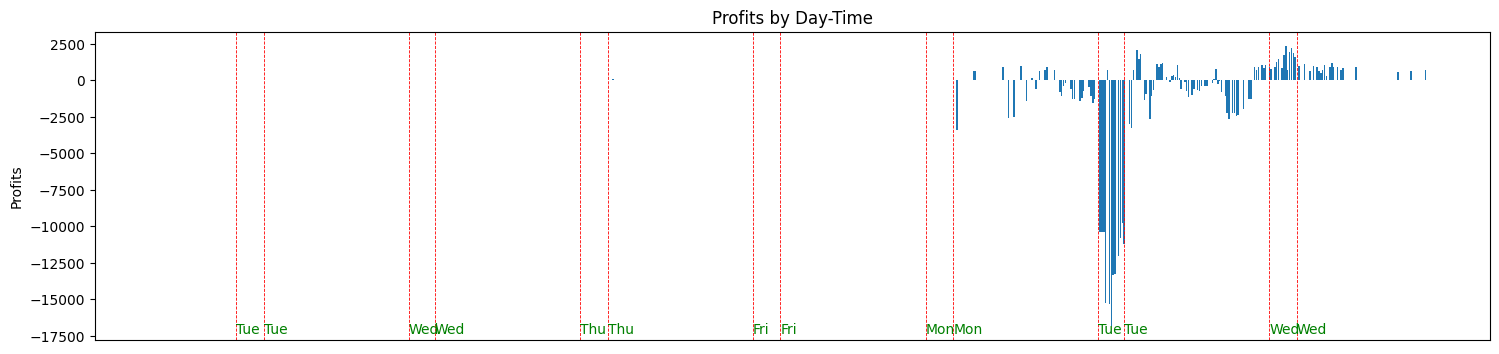

In [ ]:
draw_barchart(args, setting, points_per_page=-1, step=4, w_idx=-1, mode='test', stocks=np.arange(8),
              min_cutoff=0.5)

## Visualize pertervations

In [ ]:
from models.nlinear_attention import Model

In [ ]:
class Config:
    def __init__(self):
        self.seq_len = 600
        self.pred_len = 60
        self.enc_in = 270
        self.individual = False
        self.decomp_kernal = 25

In [ ]:
model = Model(Config())

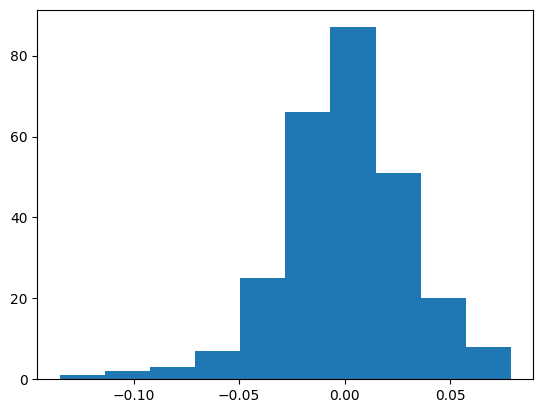

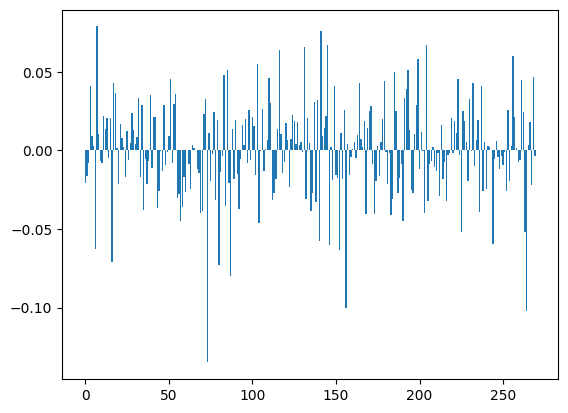

In [ ]:
model.load_state_dict(torch.load("{}/{}/{}".format(args.checkpoints, setting, sorted_weights[-1])))
attn_weights = model.Attention.weight.cpu().detach().numpy()
plt.hist(attn_weights[0]) ; plt.show()
plt.bar(np.arange(270), attn_weights[0]) ; plt.show()